In [1]:
from sklearn.linear_model import LassoCV, Lasso, RidgeCV
from sklearn.preprocessing import StandardScaler
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as tkr

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import sqlite3
sqlite_db = '/Users/lukejarmbruster/Desktop/DSI-SF-4-larmbruster/projects/capstone/facebook_news.sqlite'
conn = sqlite3.connect(sqlite_db) 
c = conn.cursor()

In [3]:
fb_news_total=pd.read_sql('SELECT * FROM fbook_news', con=conn)

In [4]:
conn.close()

In [4]:
# convert object columns from unicode to string
import string
def decoder(x):
    if not x:
        return ''
    else:
        x_ = ''.join([ch for ch in x if ch in string.printable])
        return str(x_.decode('ascii'))
object_types=fb_news_total.columns[fb_news_total.dtypes=='object']
for i in object_types:
    fb_news_total[i] = fb_news_total[i].map(decoder)

In [5]:
fb_news_total.status_published=pd.to_datetime(fb_news_total.status_published)

In [6]:
# study period from August 26, 2016 [including] to January 19, 2017 [including ](includes 73 
# before and after election day)

mask=((fb_news_total['status_published'] >= '2016-08-26') & (fb_news_total['status_published'] < '2017-01-20')) 
fb_news_total=fb_news_total.loc[mask]
fb_news_total['election_day']='same'
fb_news_total.ix[fb_news_total['status_published']<'2016-11-07','election_day']='before'
fb_news_total.ix[fb_news_total['status_published']>='2016-11-08','election_day']='after'
fb_news_total.reset_index(inplace=True, drop=True)

#fb_news_total.ix[fb_news_total['election_day']=='same','status_published'].sort_values()
del mask

In [7]:
# add time columns
fb_news_total['day_of_week']=fb_news_total.status_published.dt.weekday_name
fb_news_total['year']=fb_news_total.status_published.dt.year
fb_news_total['month']=fb_news_total.status_published.dt.month
fb_news_total['day']=fb_news_total.status_published.dt.day
fb_news_total['hour']=fb_news_total.status_published.dt.hour

In [8]:
# investigate repeats in status_id, status_message, link_name, status_link, permalink_url
# removed duplicate posts
mask=((fb_news_total.duplicated(['status_id'])) & (fb_news_total.duplicated(['status_message'])) & 
      (fb_news_total.duplicated(['link_name'])) & (fb_news_total.duplicated(['status_link'])) &
      (fb_news_total.duplicated(['permalink_url'])) & (fb_news_total.duplicated(['status_published']))
     & (fb_news_total.duplicated(['num_reactions'])))

print sum(mask)
print sum(~mask)

# remove the rows with that repeat six of the same columns elements as another row
fb_news_total=fb_news_total[~mask]
fb_news_total.reset_index(inplace=True, drop=True)
del mask

99
274618


In [9]:
fb_news_total['all_interactions']=fb_news_total['num_reactions']+fb_news_total['num_shares']+fb_news_total['num_comments']

In [11]:
# The above rows are not necessary if bootstrap pickle object is loaded instead

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, StratifiedKFold, train_test_split
from sklearn.grid_search import GridSearchCV 
import patsy

/Users/lukejarmbruster/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/lukejarmbruster/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [179]:
with open('/Users/lukejarmbruster/Desktop/DSI-SF-4-larmbruster/projects/capstone/small_sample_bootstrap_data.pkl', 'r') as f:
    small_sample = pickle.load(f)

x_subset=small_sample[['type','day_of_week','status_type','hour','num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys','all_interactions']]

for i in ['num_comments','num_shares','num_likes','num_loves','num_wows','num_hahas','num_sads','num_angrys']:
    x_subset.loc[:,i]=(1.0*x_subset.loc[:,i])/x_subset.loc[:,'all_interactions']
    x_subset.loc[x_subset['all_interactions']==0,i]=0
#    x_subset.loc[:,i]=np.sqrt(x_subset.loc[:,i])
    
#site_types=[i for i in site_types if i not in ['satire']]

#x_subset=x_subset[x_subset['type']!='satire'].reset_index(drop=True)
y_subset=pd.Series([-999] * len(x_subset['type']))

site_types=list(fb_news_total['type'].unique())
for i,item in enumerate(site_types):
    if item!='fake':
        y_subset[x_subset['type']==item]=0
    else:
        y_subset[x_subset['type']==item]=1
    
print sum(y_subset==-999)
    
weekday_types=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

x_subset.loc[:,'num_week_day']=-999

for i,item in enumerate(weekday_types):
    x_subset.loc[x_subset['day_of_week']==item,'num_week_day']=i

x_subset = x_subset.drop(['type','day_of_week','all_interactions'], 1)
x_subset['type']=y_subset
print sum(x_subset['num_week_day']==-999)
print sum(x_subset['num_comments'].isnull())



f = 'type ~ '+' + '.join([c for c in x_subset.columns if not c == 'type'])+' -1'
y, X = patsy.dmatrices(f, data=x_subset, return_type='dataframe')
X=X.values
y = y.values.ravel()


ss = StandardScaler()

Xn = ss.fit_transform(X)

params = {
#    'multi_class':['multinomial','ovr'],
#    'class_weight':['balanced',None],
    'C': np.linspace(0.0001, 10, 200),
    'penalty':['l2'],
    'solver':['liblinear']
}

mlr = LogisticRegression(max_iter=100, random_state=42)

mlr_gs = GridSearchCV(mlr, params, cv=5, verbose=1)
mlr_gs.fit(Xn, y)

print mlr_gs.best_params_
best_mlr = mlr_gs.best_estimator_


0
0
0
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
{'penalty': 'l2', 'C': 1.3066195979899498, 'solver': 'liblinear'}


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   31.2s finished


In [196]:
# excluding satire sites because it makes up only 7% of all data
x_subset=fb_news_total[['type','day_of_week','status_type','hour','num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys','all_interactions']]

for i in ['num_comments','num_shares','num_likes','num_loves','num_wows','num_hahas','num_sads','num_angrys']:
    x_subset.loc[:,i]=(1.0*x_subset.loc[:,i])/x_subset.loc[:,'all_interactions']
    x_subset.loc[x_subset['all_interactions']==0,i]=0
#    x_subset.loc[:,i]=np.sqrt(x_subset.loc[:,i])
    
#site_types=[i for i in site_types if i not in ['satire']]

#x_subset=x_subset[x_subset['type']!='satire'].reset_index(drop=True)
y_subset=pd.Series([-999] * len(x_subset['type']))

site_types=list(fb_news_total['type'].unique())
for i,item in enumerate(site_types):
    if item!='fake':
        y_subset[x_subset['type']==item]=0
    else:
        y_subset[x_subset['type']==item]=1
    
print sum(y_subset==-999)
    
weekday_types=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

x_subset.loc[:,'num_week_day']=-999

for i,item in enumerate(weekday_types):
    x_subset.loc[x_subset['day_of_week']==item,'num_week_day']=i

x_subset = x_subset.drop(['type','day_of_week','all_interactions'], 1)
x_subset['type']=y_subset
print sum(x_subset['num_week_day']==-999)
print sum(x_subset['num_comments'].isnull())



0
0
0


In [181]:
# !!!!test whether the result from dividing one series by another series!!!!

In [197]:
f = 'type ~ '+' + '.join([c for c in x_subset.columns if not c == 'type'])+' -1'
y, X = patsy.dmatrices(f, data=x_subset, return_type='dataframe')
coefs_columns=X.columns
X=X.values
y = y.values.ravel()

In [198]:
ss = StandardScaler()

Xn = ss.fit_transform(X)


In [199]:
# baseline
print "mainstream baseline: Count - ",(1.*sum(y_subset==0)), "Fraction - ",(1.*sum(y_subset==0))/len(y_subset)
print "fake baseline: Count - ",(1.*sum(y_subset==1)), "Fraction - ",(1.*sum(y_subset==1))/len(y_subset)
print "conspiracy baseline: Count - ",(1.*sum(y_subset==2)), "Fraction - ",(1.*sum(y_subset==2))/len(y_subset)
print "satire baseline: Count - ",(1.*sum(y_subset==3)), "Fraction - ",(1.*sum(y_subset==3))/len(y_subset)

mainstream baseline: Count -  161090.0 Fraction -  0.586596654262
fake baseline: Count -  113528.0 Fraction -  0.413403345738
conspiracy baseline: Count -  0.0 Fraction -  0.0
satire baseline: Count -  0.0 Fraction -  0.0


In [201]:
# train test split with 33% left out.
#ros = RandomOverSampler(random_state=42)

xtr, xte, ytr, yte = train_test_split(Xn, y, test_size=0.3,random_state=42)

cv_indices = StratifiedKFold(ytr, n_folds=5)

logreg = LogisticRegression(solver='liblinear', max_iter=200, random_state=42)#,penalty='l2',C=1.3)

lr_scores = []

for train_inds, test_inds in cv_indices:
    
    xtr_subset, ytr_subset = xtr[train_inds, :], ytr[train_inds]
#    xtr_subset, ytr_subset = ros.fit_sample(xtr_subset, ytr_subset)
    xte_subset, yte_subset = xtr[test_inds, :], ytr[test_inds]
    
    logreg.fit(xtr_subset, ytr_subset)
    lr_scores.append(logreg.score(xte_subset, yte_subset))

print 'Logistic Regression:'
print lr_scores
print np.mean(lr_scores)



Logistic Regression:
[0.66067573542799174, 0.65945327333732151, 0.65669623117538434, 0.6631379077147167, 0.66328521264143581]
0.660649672059


In [225]:
# train/test split holdout R2:
holdoutr2 = logreg.score(xte, yte)
print holdoutr2

0.659820843347
[ 0.26  0.05 -0.19 ..., -0.65 -1.66 -0.44]


In [203]:
# baseline of test set
mainstream_baseline=(1.*sum(yte==0))/len(yte)
fake_baseline=(1.*sum(yte==1))/len(yte)
conspiracy_baseline=(1.*sum(yte==2))/len(yte)
satire_baseline=(1.*sum(yte==3))/len(yte)
all_category_baseline=np.mean([mainstream_baseline,fake_baseline,conspiracy_baseline, satire_baseline])

print "mainstream baseline: ", mainstream_baseline
print "fake baseline: ", fake_baseline
print "conspiracy baseline: ", conspiracy_baseline
print "satire baseline: ", satire_baseline
print "mean of categories", all_category_baseline

mainstream baseline:  0.585973344986
fake baseline:  0.414026655014
conspiracy baseline:  0.0
satire baseline:  0.0
mean of categories 0.25


In [204]:
# prediction
print "mainstream prediction: ",(1.*sum(pred==0))/len(pred)
print "fake prediction: ",(1.*sum(pred==1))/len(pred)
print "conspiracy prediction: ",(1.*sum(pred==2))/len(pred)
print "satire prediction: ",(1.*sum(pred==3))/len(pred)

mainstream prediction:  0.727623625373
fake prediction:  0.272376374627
conspiracy prediction:  0.0
satire prediction:  0.0


In [135]:
pd.DataFrame(y_pp).head()

,0,1,2,3
0,0.723341,0.138744,0.066585,0.071330
1,0.274501,0.248061,0.238458,0.238981
2,0.250000,0.250000,0.250000,0.250000
3,0.355306,0.283780,0.226823,0.134091
4,0.941072,0.037209,0.007146,0.014573


In [254]:
# class report
print(classification_report_imbalanced(yte, pred))

# building coefs
news_types = list(y_subset.unique())
print len(news_types)

coefs = pd.DataFrame(logreg.coef_, columns=coefs_columns)
#coefs.index = news_types
coefs

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.67      0.83      0.42      0.74      0.65      0.43     48276
        1.0       0.63      0.42      0.83      0.51      0.65      0.42     34110

avg / total       0.65      0.66      0.59      0.64      0.65      0.43     82386

2


,status_type[event],status_type[link],status_type[note],status_type[photo],status_type[status],status_type[video],hour,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,num_week_day
0,-0.033677,0.044201,-0.023246,0.311843,-0.122685,-0.36766,0.048643,0.026756,0.08094,-0.279416,-0.038134,-0.150867,-0.128521,-0.540688,0.038534,0.083192


In [255]:
log_reg_coefs=coefs.transpose().sort_values(by=0, ascending=False).reset_index()

In [256]:
log_reg_coefs.rename(index=str, columns={"index":"predictors",0: "fake"},inplace=True)

In [257]:
log_reg_coefs=pd.melt(log_reg_coefs, id_vars=['predictors'], value_vars=['fake'])

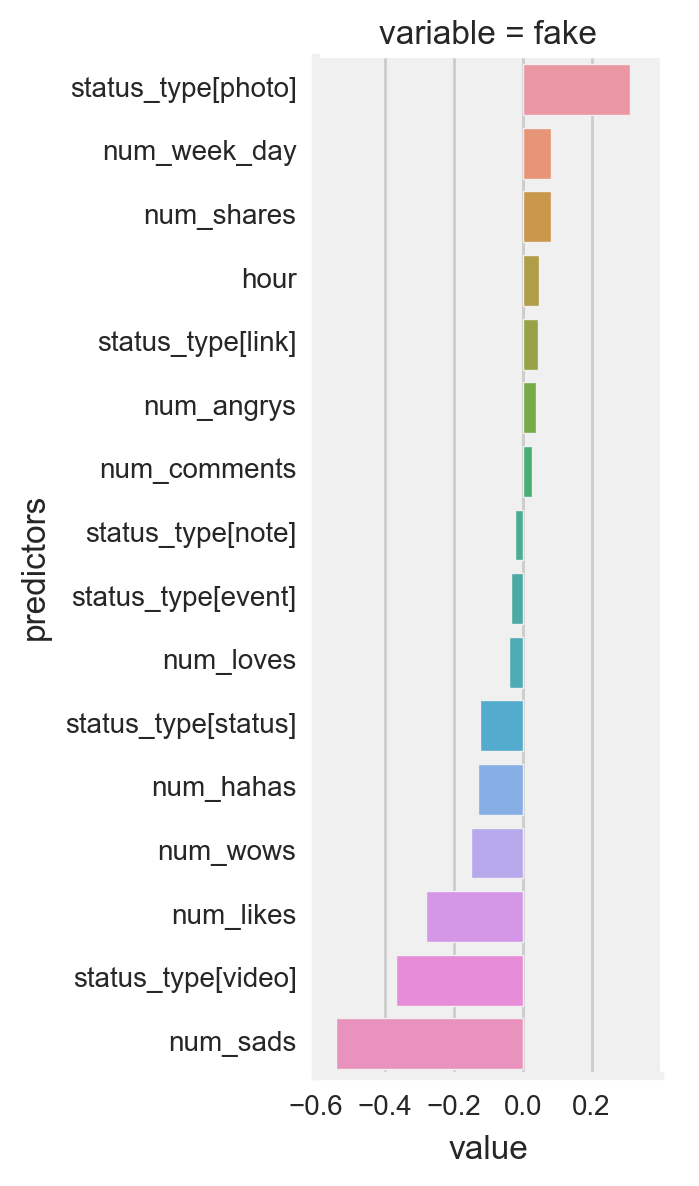

In [259]:
sns.factorplot(x='value', y='predictors', data=log_reg_coefs, col="variable",kind='bar',size=6, aspect=.6);

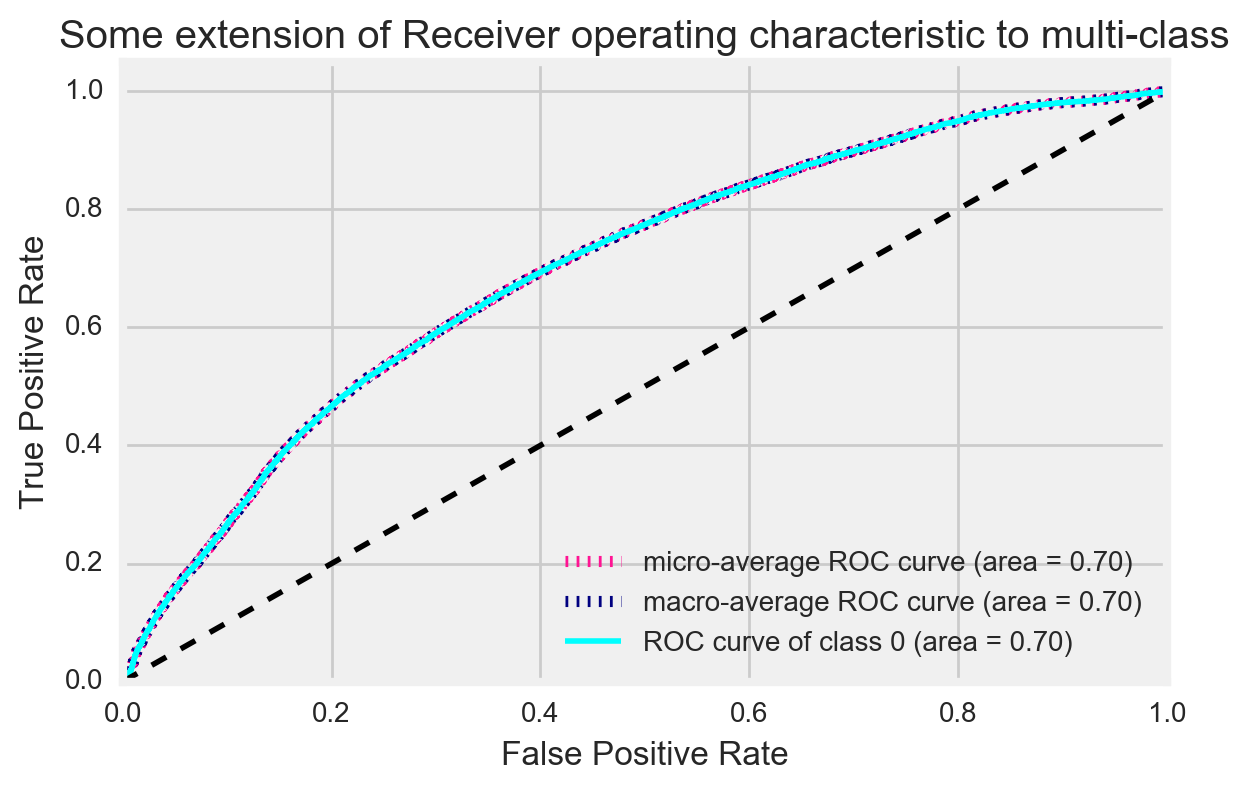

In [260]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp


bin_yte= label_binarize(yte, classes=[0, 1])
n_classes = bin_yte.shape[1]

# Get out the predicted probabilities and scores for the X observation matrix
y_prob = logreg.predict_proba(xte)
y_score = logreg.fit(xtr, ytr).decision_function(xte)

# roc_curve returns the false positive rate and true positive rates as the threshold changes
# takes in the y and the predicted probabilities of the positive class from your model.
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(bin_yte[:, i], y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(bin_yte.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue','navy']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [243]:
y_pp.ravel().shape

(164772,)

In [251]:
np.concatenate([fpr[i] for i in range(n_classes)]).shape

(32066,)

In [247]:
all_fpr.shape

(16371,)

In [244]:
y_pp.shape

(82386, 2)

In [235]:
y_score[:,1].shape

IndexError: too many indices for array

Confusion matrix, without normalization
[[40020  8256]
 [19770 14340]]


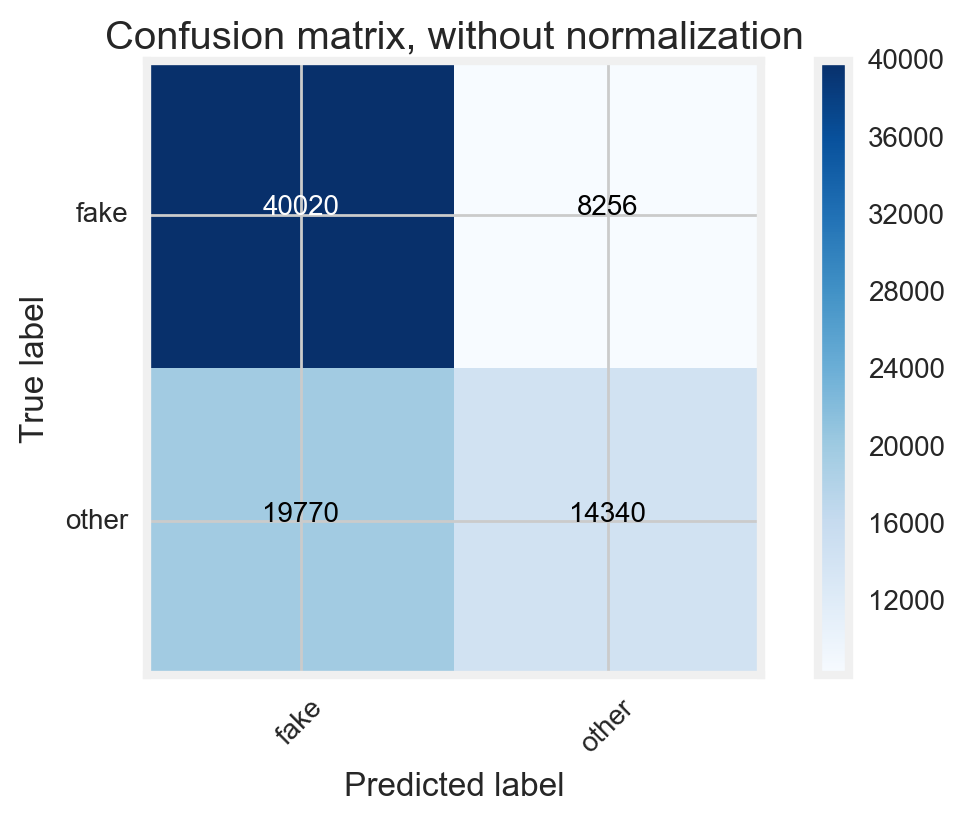

In [252]:
# plot code from scikitlearn
from sklearn.metrics import confusion_matrix,classification_report
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#class_names=['mainstream','fake','conspiracy','satire']
class_names=['fake','other']
cnf_matrix = confusion_matrix(yte, pred)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [563]:
# following numbers are inaccuracy
print (1.*(7202+2770+1999))/(17589+7202+2770+1999)
print (1.*(2607+13279+8409))/(25793+2607+13279+8409)
# conpiracy almost has more false positives than true labels
print (1.*(32+444+88))/(570+32+444+88)
# satire has more false positives than true labels
print (1.*(138+522+160))/(784+138+522+160)

#21% improvement from baseline is the highest percent difference accomplished on all labels by taking sqrt of engagement counts

0.404972936401
0.485046318479
0.497354497354
0.511221945137
